# Globally-Consistent Rule-Based Summary-Explanations for Machine Learning Models


This notebook provides code examples for a new method for understanding how predictions are made by ML models using "summary-explanations", which summarize model predictions in the data. This is similar, but also different from, methods such as [LIME](https://github.com/marcotcr/lime) and [Anchor](https://github.com/marcotcr/anchor). It is based on the paper _Globally-Consistent Rule-Based Summary-Explanations for Machine Learning Models: Application to Credit-Risk Evaluation_ by [Cynthia Rudin](https://users.cs.duke.edu/~cynthia/) and [Yaron Shaposhnik](https://sites.google.com/view/yarons/home) (https://ssrn.com/abstract=3395422). 

The gist of it, is that unlike previous methods which generate explanations that may be inconsistent with past predictions, our approach is designed to provide global consistency. By inconsistency we mean that an offered explanation  (e.g., "the model predicts high risk of defaulting of loans because of x") can be contradicted using past data (e.g., there is a customer who satisfied x but for whom the model predicts low risk of defaulting). 
This phenomenon is a result of previous approaches approximating the model _locally_ around the observation being explained whereas we take into account global patterns. We use the term "summary-explanations" because we are not explaining what the black box is computing, instead we create a summary of its predictions in a certain region of the feature space.

The specific explanations that we offer are _rule-based_, which look like this: "The model predicts High-Risk for the 742 observations satisfying $x_3\geq 80$ and $x_{21}\leq 100$" (high-risk is an arbitrary binary label). Such an explanation which is generated for a specific observation and given a dataset satisfies the following properties: 
1. It applies to the observation being explained (it must be that $x_3\geq 80$ and $x_{21}\leq 100$ for this observation).
2. In the historical data, __all__ observations satisfying the rule (that is, observations for which $x_3\geq 80$ and $x_{21}\leq 100$, of which there are exactly 742) are labelled high-risk by the model. 

__Using the code__.
1. Given a data matrix $X$ and predictions $Y_{global}$ made by an arbitrary (global) model, one first creates an "explainer":

    `explainer = ConsistentRulesExplainer(X, Y_global)`
    
    
    
2. One can then generate summary-explanations for multiple observations `X_e` whose predictions by the global model are `Y_e`:

    `df = explainer.explain(X_e, Y_e, objective='SPARSITY', n_explanations=1, max_features=999999, max_runtime=1)`

The latter returns a dataframe with multiple summary-explanations for each observation $x_e,y_e$ in $X_e,Y_e$, which are consistent with $X,Y_{global}$. The parameters of the function are:
- `objective` : specifies whether the algorithm should aim to find rules that have the smallest possible number of features (SPARSITY) or rules that are satisfied by the largest number of observations (SUPPORT)
- `n_explanations` : the maximal number of returned explanations 
- `max_features` : the maximal number of features that constitute each explanation
- `max_runtime` : the maximal running time per explanation (in seconds; a mixed integer programming solver is being used to generate summary-explanations)



__Dependencies__.
The code was developed in Python v3.7 and makes use of the following libraries:
* pandas, matplotlib, numpy, sklearn
* pulp (pip3 install PuLP==2.0)
* Guorobi (https://www.gurobi.com/)

__Note__: implementing the algorithms directly in Gurobi (instead of through PuLP) runs an order of magnitude faster.

# Toy examples

### Continuous datasets

In [1]:
# Import code (contained in a single Python file)
from ConsistentLocalRules import *

   x1  x2  y
0  10  10  0
1  10  11  0
2  10  12  1
3  11  10  0
4  11  11  0
5  11  12  0
6  12  10  1
7  12  11  0
8  12  12  0


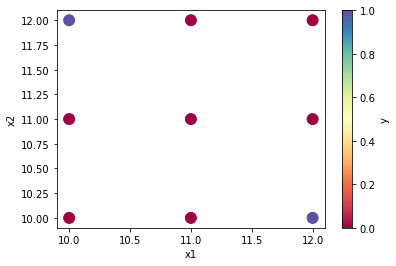

In [2]:
# Prepare a toy continuous dataset
X,Y_global,df = toy_continuous_dataset(plot=True, print_table=True)

In [3]:
# Print observation i
i = 0
X_i, Y_global_i = X.iloc[[i],:], Y_global.iloc[[i]]
print('Observation %d features: %s'%(i,str(X_i.values)))
print('Model prediction for observation %d: %s'%(i,str(Y_global_i.values)))

Observation 0 features: [[10 10]]
Model prediction for observation 0: [0]


In [4]:
# Create an explainer (a globally-consistent summary-explanation generator) based on the dataset X and the model whose predictions for X are Y_global
explainer = ConsistentRulesExplainer(X, Y_global)        

In [5]:
# Generate summary explanations for observation i (here we optimize sparsity; X_i is a dataframe formatted similarly to X)
df_explanations = explainer.explain(X_i, Y_global_i, objective='SPARSITY', n_explanations=10, max_features=9999, max_runtime=60)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-10


In [6]:
df_explanations

,#Observation,#Explanation,Rule,Prediction,Support,#Features,Runtime,Algorithm
0,0,0,"x1<=10.00, x2<=10.00",0,1,2,0.0,ContMinSetCover
1,0,1,"10.00<=x2<=10.00, x1<=10.00",0,1,2,0.0,ContMinSetCover
2,0,2,"10.00<=x1<=10.00, x2<=10.00",0,1,2,0.0,ContMinSetCover
3,0,3,"10.00<=x1<=10.00, 10.00<=x2<=10.00",0,1,2,0.0,ContMinSetCover


Observe that
* 4 summary explanations were generated for observation i=0
* The algorithm used to find this rule is ContMinSetCover which is used when the objective is sparsity and the dataset has continuous features

In [7]:
# Generate summary explanations for observation i (this time optimize support)
df_explanations = explainer.explain(X_i, Y_global_i, objective='SUPPORT', n_explanations=10, max_features=9999, max_runtime=60)

In [8]:
# Display summary-explanations
df_explanations

,#Observation,#Explanation,Rule,Prediction,Support,#Features,Runtime,Algorithm
0,0,0,"x1<=11.00, x2<=11.00",0,4,2,0.0,ContMaxSupport


A single summary-explanation was returned for observation 0. Note that now that we specified objective=SUPPORT, the resulting rule has a larger support (support=4) comparing to the rules obtained when only aimed for sparsity. The algorithm used is ContMaxSupport, which applies dynamic programming to "expand" the solutions returned by ContMinSetCover. In this particular case (when i=0) the expanded explanations of the 4 sparse explanations coincide, which is why a single summary-explanation is returned. 

### Binary datasets
Different algorithms are used to explain binary datasets (features are binary). These are: BinMinSetCover and BinMaxSupport.

In [9]:
# Import code (contained in a single Python file)
from ConsistentLocalRules import *

  x1 x2  y
0  0  0  1
1  0  1  0
2  1  0  0
3  1  1  0


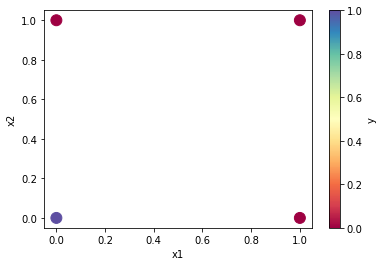

In [10]:
# Prepare a toy binary dataset
X,Y_global,df = toy_binary_dataset(plot=True, print_table=True)

In [11]:
# Create an explainer (a globally-consistent summary-explanation generator) based on the dataset X and the model whose predictions for X are Y_global
explainer = ConsistentRulesExplainer(X, Y_global)        

In [12]:
# Generate summary explanations for observation i (here we optimize sparsity; X_i is a dataframe formatted similarly to X)
df_explanations = explainer.explain(X, Y_global, objective='SPARSITY', n_explanations=10, max_features=9999, max_runtime=60)

In [13]:
df_explanations

,#Observation,#Explanation,Rule,Prediction,Support,#Features,Runtime,Algorithm
0,0,0,"x1<=0.00, x2<=0.00",1,1,2,0.0,BinMinSetCover
1,1,0,x2>=1.00,0,2,1,0.0,BinMinSetCover
2,1,1,"x2>=1.00, x1<=0.00",0,1,2,0.0,BinMinSetCover
3,2,0,x1>=1.00,0,2,1,0.0,BinMinSetCover
4,2,1,"x1>=1.00, x2<=0.00",0,1,2,0.0,BinMinSetCover
5,3,0,x2>=1.00,0,2,1,0.0,BinMinSetCover
6,3,1,x1>=1.00,0,2,1,0.0,BinMinSetCover
7,3,2,"x1>=1.00, x2>=1.00",0,1,2,0.0,BinMinSetCover


In this case we simultaneously generate explanations for 4 observations. The first column in the resulting dataframe ("	#Observation") tells us the observation number (according to its position in $X$). For each observation being explained there could be multiple summary-explanations which are numbered sequentially in the second column ("#Explanation"). Here we optimized for sparsity and the algorithm used was BinMinSetCover. 

In [14]:
# Generate summary explanations for observation i (this time optimize support)
df_explanations = explainer.explain(X, Y_global, objective='SUPPORT', n_explanations=10, max_features=9999, max_runtime=60)

In [15]:
# Display summary-explanations
df_explanations

,#Observation,#Explanation,Rule,Prediction,Support,#Features,Runtime,Algorithm
0,0,0,"x1<=0.00, x2<=0.00",1,1,2,0.0,BinMaxSupport
1,1,0,x2>=1.00,0,2,1,0.0,BinMaxSupport
2,1,1,"x2>=1.00, x1<=0.00",0,1,2,0.0,BinMaxSupport
3,2,0,x1>=1.00,0,2,1,0.0,BinMaxSupport
4,2,1,"x1>=1.00, x2<=0.00",0,1,2,0.0,BinMaxSupport
5,3,0,x2>=1.00,0,2,1,0.0,BinMaxSupport
6,3,1,x1>=1.00,0,2,1,0.0,BinMaxSupport
7,3,2,"x1>=1.00, x2>=1.00",0,1,2,0.0,BinMaxSupport


When maximizing support we use the algorithm BinMaxSupport. The results are pretty for similar in 2 dimensional binary datasets.

# Real data

Data source: https://community.fico.com/s/explainable-machine-learning-challenge

The problem describes a binary classification problem for predicting defaulting on HELOC loans: "Bad" (1) vs. "Good" (0).

### Setup: prepare data and train global model to be explained

In [16]:
# Load data
df = pd.read_csv('heloc_dataset_v1.csv')
df.head(2)

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0


In [17]:
# Construct data matrix and labels
X = df.iloc[:,1:]
Y = pd.Series((df.iloc[:,0]=='Bad').astype(int)) # transform "Bad" to 1 and "Good" to 0

In [18]:
# Train model (for brevity we skip preprocessing and split to train/test data)
from sklearn import linear_model
clf_log_reg = linear_model.LogisticRegression(max_iter=10000, random_state=0).fit(X, Y) 

In [19]:
# Evaluation (in-sample)
from sklearn.metrics import accuracy_score
print('Model accuracy: %.3f'%accuracy_score(Y, clf_log_reg.predict(X)))

Model accuracy: 0.719


In [20]:
# Model predictions
Y_global = pd.Series(clf_log_reg.predict(X))

### Generate summary-explanations

In [21]:
# Import code (contained in a single Python file)
from ConsistentLocalRules import *

In [22]:
# Print observation i
i = 0
X_i, Y_global_i = X.iloc[[i],:], Y_global.iloc[[i]]
print('Observation %d features: %s'%(i,str(X_i.values)))
print('Model prediction for observation %d: %s'%(i,str(Y_global_i.values)))

Observation 0 features: [[ 55 144   4  84  20   3   0  83   2   3   5  23   1  43   0   0   0  33
   -8   8   1   1  69]]
Model prediction for observation 0: [1]


In [23]:
# Create an explainer (a globally-consistent summary-explanation generator) based on the dataset X and the model whose predictions for X are Y_global
explainer = ConsistentRulesExplainer(X, Y_global)        

In [24]:
# Generate summary explanations for observation i (here we optimize sparsity; X_i is a dataframe formatted similarly to X)
df_explanations = explainer.explain(X_i, Y_global_i, objective='SPARSITY', n_explanations=3, max_features=9999, max_runtime=60)

In [25]:
df_explanations

,#Observation,#Explanation,Rule,Prediction,Support,#Features,Runtime,Algorithm
0,0,0,"MSinceMostRecentDelq>=2.00, ExternalRiskEstima...",1,204,2,5.3,ContMinSetCover
1,0,1,"NumTrades60Ever2DerogPubRec>=3.00, ExternalRis...",1,85,2,5.3,ContMinSetCover
2,0,2,"ExternalRiskEstimate<=55.00, NumTrades90Ever2D...",1,730,2,5.3,ContMinSetCover


In [26]:
# Print summary explanations
print(df_explanations.loc[:,"Rule"].values)

['MSinceMostRecentDelq>=2.00, ExternalRiskEstimate<=55.00'
 'NumTrades60Ever2DerogPubRec>=3.00, ExternalRiskEstimate<=55.00'
 'ExternalRiskEstimate<=55.00, NumTrades90Ever2DerogPubRec<=-0.00']


We created 3 sparse summary-explanations for observation i=0. The first rule states that: For all 204 observations in the data  where `MSinceMostRecentDelq>=2.00` and `ExternalRiskEstimate<=55.00` the global model predicts high-risk of defaulting ("Bad" or 1).

In [27]:
# Generate summary explanations for observation i (this time optimize support)
df_explanations = explainer.explain(X_i, Y_global_i, objective='SUPPORT', n_explanations=3, max_features=9999, max_runtime=60)

In [28]:
# Display summary-explanations
df_explanations

,#Observation,#Explanation,Rule,Prediction,Support,#Features,Runtime,Algorithm
0,0,0,"ExternalRiskEstimate<=57.00, NumTrades90Ever2D...",1,942,2,0.3,ContMaxSupport
1,0,1,"MSinceMostRecentDelq>=2.00, ExternalRiskEstima...",1,326,2,0.1,ContMaxSupport
2,0,2,"NumTrades60Ever2DerogPubRec>=3.00, ExternalRis...",1,287,2,0.3,ContMaxSupport


In [29]:
print(df_explanations.loc[:,"Rule"].values)

['ExternalRiskEstimate<=57.00, NumTrades90Ever2DerogPubRec<=-0.00'
 'MSinceMostRecentDelq>=2.00, ExternalRiskEstimate<=56.00'
 'NumTrades60Ever2DerogPubRec>=3.00, ExternalRiskEstimate<=61.00']


Here we see the explanations for observation i=0 when maximizing support. While the features constituting the summary-explanations are similar, the threshold values in the rules are different (e.g., ExternalRiskEstimate<=55.00 vs. ExternalRiskEstimate<=57.00), resulting in a higher support values without harming sparsity. 